In [1]:
import numpy as np
import pandas as pd
import sys,random,os,csv, random
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn import linear_model
from sklearn import neural_network

from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

In [2]:
def dict_subtract(vec1, vec2):
    """treat vec1 and vec2 as dict representations of sparse vectors"""
    out = defaultdict(float)
    out.update(vec1)
    for k in vec2: 
        if k not in out:
            out[k] = 0
        out[k] -= vec2[k]
    return dict(out)

def dict_add(vec1, vec2):
    out = defaultdict(float)
    out.update(vec1)
    for k in vec2:
        if k not in out:
            out[k] = 0
        out[k] += vec2[k]
    return dict(out)

def dict_dotprod(d1, d2):
    """Return the dot product (aka inner product) of two vectors, where each is
    represented as a dictionary of {index: weight} pairs, where indexes are any
    keys, potentially strings.  If a key does not exist in a dictionary, its
    value is assumed to be zero."""
    smaller = d1 if len(d1)<len(d2) else d2  # BUGFIXED 20151012
    total = 0
    for key in smaller.keys():
        total += d1.get(key,0) * d2.get(key,0)
    return total

def dict_const_mult(vec, const):
    out = defaultdict(float)
    out.update(vec)
    for k in vec: out[k] = out[k] * const
    return dict(out)

def dict_argmax(dct):
    return max(dct.keys(), key=lambda k: dct[k])

In [3]:
def plot_accuracy_vs_iteration(accuracies, num_iter):
    plt.plot(range(num_iter), accuracies)
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Num. iterations vs Accuracy')
    plt.show()
    
def plot_label_stats(label_counts):        
    labels = []
    counts = []
    for k in label_counts.keys():
        labels.append(k)
        counts.append(label_counts[k])
        
    print labels
    print counts
    print ""
    print ""
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.show()

In [4]:
# class Perceptron(object):
    
#     def __init__(self, eta=0.01, n_iter=50):
#         self.eta = eta #learning rate eta
#         self.n_iter = n_iter #number of epochs (passes)
#         self._weights = defaultdict(float)
        
#     def fit(self, train_tweets, gold_labels, test_tweets=None, test_gold_labels=None):
        
#         # self._errors = [] # array of misclassifications in every epoch (pass)
#         accuracies = []
#         train_data = [(t, l) for t, l in zip(train_tweets, gold_labels)]
#         for i in range(self.n_iter):
#             random.shuffle(train_data)
#             for tweet, gold_label in train_data:
#                 predict_label = self.predict(tweet)
                
#                 if predict_label != gold_label:
#                     pred_feats = features_per_tweet(tweet, predict_label)
#                     gold_feats = features_per_tweet(tweet, gold_label)
                    
#                     diff_feats = dict_subtract(gold_feats, pred_feats)
#                     update = dict_const_mult(diff_feats, self.eta)
#                     self._weights.update(dict_add(self._weights, update))
                
#             print
#             print
#             print "Iter. ", i, " - TRAIN RAW EVAL"
#             accuracy = self.do_evaluation(train_tweets, gold_labels)
#             accuracies.append(accuracy)
#             if test_tweets and test_gold_labels:
#                 print("Iter. ", i, " - TEST  RAW EVAL")
#                 self.do_evaluation(test_tweets, test_gold_labels)
                
#         plot_accuracy_vs_iteration(accuracies, self.n_iter)
#         return self
    
#     def do_evaluation(self, tweets, labels):
#         num_correct, num_total = 0.0,0.0
#         for tweet, label in zip(tweets, labels):
#             predict_label = self.predict(tweet)
#             num_correct += 1 if predict_label == label else 0
#             num_total += 1
#         print("%d/%d = %.4f accuracy" % (num_correct, num_total, num_correct/float(num_total)))
#         return num_correct/num_total
        
#     def predict(self, tweet):
#         # "one-vs-all" strategy later
#         label_dict = {}
#         hillary_features = features_per_tweet(tweet, "Hillary Clinton")
#         hillary_linear_comb = dict_dotprod(hillary_features, self._weights)
#         label_dict["Hillary Clinton"] = hillary_linear_comb
        
#         atheism_features = features_per_tweet(tweet, "Atheism")
#         atheism_linear_comb = dict_dotprod(hillary_features, self._weights)
#         label_dict["Atheism"] = atheism_linear_comb
        
#         climate_features = features_per_tweet(tweet, "Climate Change is a Real Concern")
#         climate_linear_comb = dict_dotprod(hillary_features, self._weights)
#         label_dict["Climate Change is a Real Concern"] = climate_linear_comb
        
#         donald_features = features_per_tweet(tweet, "Donald Trump")
#         donald_linear_comb = dict_dotprod(hillary_features, self._weights)
#         label_dict["Donald Trump"] = donald_linear_comb
        
#         feminist_features = features_per_tweet(tweet, "Feminist Movement")
#         feminist_linear_comb = dict_dotprod(hillary_features, self._weights)
#         label_dict["Feminist Movement"] = feminist_linear_comb
        
#         abortion_features = features_per_tweet(tweet, "Legalization of Abortion")
#         abortion_linear_comb = dict_dotprod(hillary_features, self._weights)
#         label_dict["Legalization of Abortion"] = abortion_linear_comb
        
#         return dict_argmax(label_dict)
    
#         if hillary_linear_comb > len(tweet):
#             return "Hillary Clinton"
#         elif atheism_linear_comb > len(tweet):
#             return "Atheism"
#         elif climate_linear_comb > len(tweet):
#             return "Climate Change is a Real Concern"
#         elif feminist_linear_comb > len(tweet):
#             return "Feminist Movement"
#         elif abortion_linear_comb > len(tweet):
#             return "Legalization of Abortion"
#         else:
#             return "Donald Trump"
        
                                                                 

In [5]:
# def features_per_tweet(tweet, label):
#     features = {}
#     tweet_tokens = tweet.lower().split()
#     for token in tweet_tokens:
#         if token not in features:
#             features[token] = 1
#         else:
#             features[token] += 1
            
#         if "token=%s_label=%s" % (token, label) not in features:
#             features["token=%s_label=%s" % (token, label)] = 5
#         else:
#             features["token=%s_label=%s" % (token, label)] += 1
            
#     # bi-gram features
#     for i in range(len(tweet_tokens)-1):
#         if "prevToken=%s_nextToken=%s" % (tweet_tokens[i], tweet_tokens[i+1]) not in features:
#             features["prevToken=%s_nextToken=%s" % (tweet_tokens[i], tweet_tokens[i+1])] = 5
#         else:
#             features["prevToken=%s_nextToken=%s" % (tweet_tokens[i], tweet_tokens[i+1])] += 1
        
#         if "prevToken=%s_nextToken=%s_label=%s" % (tweet_tokens[i], tweet_tokens[i+1], label) not in features:
#             features["prevToken=%s_nextToken=%s_label=%s" % (tweet_tokens[i], tweet_tokens[i+1], label)] = 5
#         else:
#             features["prevToken=%s_nextToken=%s_label=%s" % (tweet_tokens[i], tweet_tokens[i+1], label)] += 1
           
#     # trigram features
#     for i in range(len(tweet_tokens)-2):
#         if "token1=%s_token2=%s_token3=%s" % (tweet_tokens[i], tweet_tokens[i+1], tweet_tokens[i+2]) not in features:
#             features["token1=%s_token2=%s_token3=%s" % (tweet_tokens[i], tweet_tokens[i+1], tweet_tokens[i+2])] = 1
#         else:
#             features["token1=%s_token2=%s_token3=%s" % (tweet_tokens[i], tweet_tokens[i+1], tweet_tokens[i+2])] += 1
        
#         if "token1=%s_token2=%s_token3=%s_label=%s" % (tweet_tokens[i], tweet_tokens[i+1], tweet_tokens[i+2], label) not in features:
#             features["token1=%s_token2=%s_token3=%s_label=%s" % (tweet_tokens[i], tweet_tokens[i+1], tweet_tokens[i+2], label)] = 5
#         else:
#             features["token1=%s_token2=%s_token3=%s_label=%s" % (tweet_tokens[i], tweet_tokens[i+1], tweet_tokens[i+2], label)] += 1
#     return features

In [6]:
# def process_file(file_path, start=None, end=None):
#     tweets, gold_labels, stances = [], [], []
#     label_counts = {"Hillary Clinton": 0,"Atheism": 0,"Climate Change is a Real Concern": 0,"Feminist Movement": 0,"Legalization of Abortion": 0,"Donald Trump": 0}
    
#     with open(file_path, 'r') as f:
#         lines = f.read().splitlines()
#         num_tweets = len(lines) - 1 # not counting header
    
#         start = start if start else 1
#         end = end + 1 if end else len(lines)
#         for line in lines[start:end]:
#             fields = line.split('\t')
#             tweets.append(fields[2])
#             gold_labels.append(fields[1])
#             stances.append(fields[3])
#             label_counts[fields[1]] += 1
#             num_tweets += 1
            
#             ##### CHECK #####
# #             print "Gold label", fields[1]
# #             print "Tweet", fields[2]
# #             print "Stance", fields[3]
# #             print

#     return tweets, gold_labels, label_counts, stances, num_tweets

In [44]:
class PerceptronSKLearn(object):
    def __init__(self):
        self.targets = ['Atheism', 'Legalization of Abortion', 'Feminist Movement', 'Climate Change is a Real Concern', 'Hillary Clinton']
        self.target_counts = defaultdict(int)
        self.total_count = 0
        self.feature_count = defaultdict(int)
        self.X_train = []
        self.X_test = []
        self.y_train = []
        self.y_test = []
        self.target_dict = {'Atheism':0, 'Legalization of Abortion':1, 'Feminist Movement':2,
                        'Climate Change is a Real Concern':3, 'Hillary Clinton':4}
        
    def vectorize_data(self, train_file, start=None, end=None):
        with open(train_file, 'r') as f:
            lines = f.read().splitlines()
            start = start if start else 1
            end = end+1 if end else len(lines)
            for line in lines[start:end]:
                fields = line.split('\t')
                self.total_count += 1
                self.target_counts[fields[1]] += 1
                self.X_train.append(fields[2])
                self.y_train.append(self.target_dict[fields[1]])
        self.X_train = np.array(self.X_train)
        self.y_train = np.array(self.y_train)
            
    def prep_data(self, train_file, start=None, end=None):
        data = []
        conv_dict = {'Atheism':0, 'Legalization of Abortion':1, 'Feminist Movement':2,
                        'Climate Change is a Real Concern':3, 'Hillary Clinton':4}

        # read data
        with open(train_file, 'r') as f:
            lines = f.read().splitlines()
            start = start if start else 1
            end = end+1 if end else len(lines)
            for line in lines[start:end]:
                fields = line.split('\t')
                self.total_count += 1
                self.target_counts[fields[1]] += 1
                tokens = fields[2].lower().split()
                curr_tweet_feature_count = defaultdict(int)
                
                # unigram counts
                for token in tokens:
                    tt_pair_key = "token=%s_target=%s" % (token, fields[1])
                    self.feature_count[token] += 1
                    self.feature_count[tt_pair_key] += 1
                    curr_tweet_feature_count[token] += 1
                    curr_tweet_feature_count[tt_pair_key] += 1
                    
                # bigram counts
                for i in range(len(tokens) - 1):
                    bigram_key = "token1=%s_token2=%s" % (tokens[i], tokens[i+1])
                    self.feature_count[bigram_key] += 1
                    curr_tweet_feature_count[bigram_key] += 1
                    
#                 # trigram counts
#                 for i in range(len(tokens) - 2):
#                     trigram_key = "token1=%s_token2=%s_token3=%s" % (tokens[i], tokens[i+1], tokens[i+2])
#                     self.feature_count[trigram_key] += 1
#                     curr_tweet_feature_count[trigram_key] += 1
                    
                data.append([conv_dict[fields[1]], curr_tweet_feature_count])

        # generate features
        print "Number of training tweets", self.total_count
        print "Number of features", len(self.feature_count)
        self.labels = []
        self.training_data = []
        for item in data:
            self.labels.append(item[0])
            curr_features = []
            for token, count in self.feature_count.iteritems():
                curr_features.append(item[1][token])
            self.training_data.append(curr_features)
        self.training_data = np.array(self.training_data)
        self.labels = np.array(self.labels)
    
    def train_pipeline(self, num_iter=10, eta=0.01):
        self.base_clf = linear_model.Perceptron(n_iter=num_iter, eta0=eta)
        self.clf = Pipeline([
            ('vectorizer', CountVectorizer(analyzer='word', ngram_range=(1, 2), decode_error='ignore')),
            ('tfidf', TfidfTransformer()),
            ('clf', OneVsRestClassifier(self.base_clf))])
        self.clf.fit(self.X_train, self.y_train)
        
    def predict(self, tweet):
        curr_tweet_feature_count = defaultdict(int)
        curr_features = []
        tokens = tweet.split(' ')
        for token in tokens:
            curr_tweet_feature_count[token] += 1
            
        for i in range(len(tokens) - 1):
            bigram_key = "token1=%s_token2=%s" % (tokens[i], tokens[i+1])
            curr_tweet_feature_count[bigram_key] += 1
            
#         for i in range(len(tokens) - 2):
#             trigram_key = "token1=%s_token2=%s_token3=%s" % (tokens[i], tokens[i+1], tokens[i+2])
#             curr_tweet_feature_count[trigram_key] += 1
            
        for feature, count in self.feature_count.iteritems():
            curr_features.append(curr_tweet_feature_count[feature])
        return self.targets[self.clf.predict(np.array(curr_features).reshape(1, -1))]
    
    def do_eval(self, test_file, start=None, end=None):
        with open(test_file, 'r') as f:
            lines = f.read().splitlines()
            start = start if start else 1
            end = end+1 if end else len(lines)
            for line in lines[start:end]:
                fields = line.split('\t')
                self.X_test.append(fields[2])
                self.y_test.append(self.target_dict[fields[1]])
        self.X_test = np.array(self.X_test)
        self.y_test = np.array(self.y_test)
        predicted = self.clf.predict(self.X_test)
        
        return np.sum(predicted == self.y_test) / float(len(self.y_test))

0.290632506005
0.305044035228
0.295436349079
0.317854283427
0.361889511609
0.39871897518
0.395516413131
0.515612489992
0.53162530024
0.541232986389
0.597277822258
0.611689351481
0.701361088871


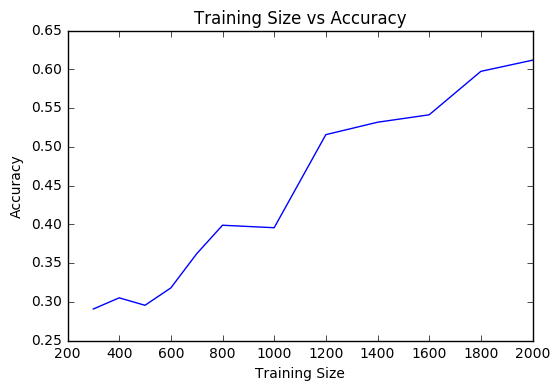

In [45]:
# PATH_TO_DATA = os.path.join(os.getcwd(), 'twitter_dataset')
PATH_TO_DATA = 'twitter_dataset'
TRAIN_DIR, TRAIN_FILE = os.path.join(PATH_TO_DATA, 'train'), "trainingdata-all-annotations.txt"
TEST_DIR, TEST_FILE = os.path.join(PATH_TO_DATA, 'test'), "testdata-taskA-all-annotations.txt"

train_path = os.path.join(TRAIN_DIR, TRAIN_FILE)
test_path = os.path.join(TEST_DIR, TEST_FILE)

##### OWN IMPLEMENTATION #####
# train_tweets, train_gold_labels, train_label_counts, train_stances, train_file_size = process_file(os.path.join(TRAIN_DIR, TRAIN_FILE), end=600)
# test_tweets, test_gold_labels, test_label_counts, test_stances, test_file_size = process_file(os.path.join(TEST_DIR, TEST_FILE))
# print "Training label counts", train_label_counts
# ppn = Perceptron()
# ppn.fit(train_tweets, train_gold_labels)

##### SKLEARN IMPLEMENTATION #####
accuracies = []
training_size =  [300, 400, 500, 600, 700, 800, 1000, 
                  1200, 1400, 1600, 1800, 2000, None] #None means use all training dataset
for num_train in training_size:
    skppn = PerceptronSKLearn()
    skppn.vectorize_data(train_path, end=num_train)
    skppn.train_pipeline(num_iter=50, eta=0.1)
    acc = skppn.do_eval(test_path)
    print acc
    accuracies.append(acc)
    
plt.plot(training_size, accuracies)
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title('Training Size vs Accuracy')
plt.show()